<a href="https://colab.research.google.com/github/Carlosmtp/ML-CO2-Emissions/blob/main/ML_DT_CO2_Emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Informe Machine Learning *C02 Emissions* (árboles de decisión ) 🚗💨

#### *Carlos Mauricio Tovar Parra - 1741699*
#### *Santiago Duque Chacón - 2180099*
---

### Resumen

El presente informe, se centra en la experimentación con técnicas de machine learning para predecir las emisiones de dióxido de carbono (CO2) en vehículos. Utilizando un conjunto de datos de 1067 vehículos, el informe desarrolla modelos predictivos basados en las características de los vehículos: tamaño del motor (ENGINESIZE), cantidad de cilindros (CYLINDERS), consumo de combustible en ciudad (FUELCONSUMPTION_CITY) y en carretera (FUELCONSUMPTION_HWY). La variable objetivo es CO2EMISSIONS, clasificada en bajas (0) y altas (1) emisiones.

El objetivo del informe es implementar árboles de decisión, configurando y probando diferentes configuraciones para identificar la combinación de hiperparámetros que maximiza la precisión predictiva.

*Tabla de atributos:*

| Número | Atributo                   | Descripción                                                        |
|--------|----------------------------|--------------------------------------------------------------------|
| 1      | ENGINESIZE                 | Tamaño del motor en litros                                         |
| 2      | CYLINDERS                  | Cantidad de cilindros que posee el motor                           |
| 3      | FUELCONSUMPTION_CITY       | Consumo de combustible del vehículo en zona urbana (L/100 km)      |
| 4      | FUELCONSUMPTION_HWY        | Consumo de combustible del vehículo en zona extraurbana (L/100 km) |
| 5      | CO2EMISSIONS               | Emisiones de CO2 del vehículo (0: Bajas, 1: Altas)                 |


*Ejemplo instancia de datos:*

| Atributo | 1   | 2  | 3    | 4   | 5 |
|----------|-----|----|------|-----|---|
| Valor    | 3.7 | 6  | 13.4 | 9.5 | 1 |


*Librerías Usadas:*
- numpy
- pandas
- sklearn

In [3]:
import numpy as np
import pandas as pd
import sklearn

### 1) Se lee el archivo

In [4]:
dataset_url = ("https://raw.githubusercontent.com/Carlosmtp/ML-CO2-Emissions/main/CO2%20emissions%20data.csv")
dataset = pd.read_csv(dataset_url, sep=",")
dataset.columns = ["ENGINESIZE",	"CYLINDERS",	"FUELCONSUMPTION_CITY",	"FUELCONSUMPTION_HWY",	"CO2EMISSIONS"]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ENGINESIZE            1067 non-null   float64
 1   CYLINDERS             1067 non-null   int64  
 2   FUELCONSUMPTION_CITY  1067 non-null   float64
 3   FUELCONSUMPTION_HWY   1067 non-null   float64
 4   CO2EMISSIONS          1067 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 41.8 KB


*Variables cuantitativas continuas:*

In [5]:
dataset.select_dtypes(include=['float64']).describe()

,ENGINESIZE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY
count,1067.000000,1067.000000,1067.000000
mean,3.346298,13.296532,9.474602
std,1.415895,4.101253,2.794510
min,1.000000,4.600000,4.900000
25%,2.000000,10.250000,7.500000
50%,3.400000,12.600000,8.800000
75%,4.300000,15.550000,10.850000
max,8.400000,30.200000,20.500000


*Variables cuantitativas discretas:*

In [6]:
dataset.select_dtypes(include=['int64']).describe()

,CYLINDERS,CO2EMISSIONS
count,1067.000000,1067.000000
mean,5.794752,0.461106
std,1.797447,0.498719
min,3.000000,0.000000
25%,4.000000,0.000000
50%,6.000000,0.000000
75%,8.000000,1.000000
max,12.000000,1.000000


## 2) Se separan los datos en conjuntos de entrenamiento y prueba (80%, 20%)

In [7]:
from sklearn.model_selection import train_test_split
N=len(dataset)
cTrain=int(N*0.8)
cTest=N-cTrain
print(N,cTrain,cTest)
train_data,test_data= sklearn.model_selection.train_test_split(dataset, train_size=cTrain, test_size=cTest)

1067 853 214


In [8]:
dataset.shape

(1067, 5)

In [9]:
dataset.head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,CO2EMISSIONS
0,2.0,4,9.9,6.7,0
1,2.4,4,11.2,7.7,0
2,1.5,4,6.0,5.8,0
3,3.5,6,12.7,9.1,0
4,3.5,6,12.1,8.7,0


## 3) Se normalizan e imputan los datos

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

data_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

attribs = dataset.columns[0:-1]
full_pipeline = ColumnTransformer([
    ("num", data_pipeline, attribs),
])

X_train = full_pipeline.fit_transform(train_data)
X_train.shape

(853, 4)

In [11]:
X_train[0,:]

array([-0.94066315, -0.99646069, -0.84211187, -0.83902399])

In [12]:
y_train = train_data["CO2EMISSIONS"]
y_train

823     0
914     1
931     0
1043    0
471     1
       ..
790     0
168     1
275     0
341     0
638     0
Name: CO2EMISSIONS, Length: 853, dtype: int64

## 4) Se configura el primer modelo variando max_depth de 1 hasta 10

In [13]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

models1 = []
scores1 = []

for i in range(10):
  model = tree.DecisionTreeClassifier(criterion="gini",splitter="best",random_state=123,max_depth=i+1)
  model.fit(X_train, y_train)
  models1.append(model)
  score = cross_val_score(model, X_train, y_train, cv=5)
  scores1.append(score.mean())

print(scores1)

[0.9706983144134848, 0.9695287237702098, 0.9671895424836601, 0.9624905400756795, 0.9730306157550739, 0.9730374957000343, 0.9718610251117991, 0.9730306157550739, 0.9718610251117991, 0.9730306157550739]


## 6) Se configura el segundo modelo variando max_depth de 1 hasta 10

In [14]:
models2 = []
scores2 = []

for i in range(10):
  model = tree.DecisionTreeClassifier(criterion="entropy",splitter="best",random_state=123,max_depth=i+1)
  model.fit(X_train, y_train)
  models2.append(model)
  score = cross_val_score(model, X_train, y_train, cv=5)
  scores2.append(score.mean())

print(scores2)

[0.9706983144134848, 0.968359133126935, 0.9695356037151702, 0.9789129686962503, 0.9718679050567596, 0.9671689026487789, 0.9683384932920538, 0.97187478500172, 0.9683384932920538, 0.9683384932920538]


## 8) Se configura el tercer modelo variando max_depth de 1 hasta 10

In [15]:
models3 = []
scores3 = []

for i in range(10):
  model = tree.DecisionTreeClassifier(criterion="entropy",splitter="random",random_state=123,max_depth=i+1)
  model.fit(X_train, y_train)
  models3.append(model)
  score = cross_val_score(model, X_train, y_train, cv=5)
  scores3.append(score.mean())

print(scores3)

[0.8194496044031647, 0.8194496044031647, 0.9260887512899897, 0.8922050223598212, 0.8968971448228414, 0.9320399036807705, 0.9379153766769865, 0.9285242518059855, 0.9519160646714827, 0.9542758857929137]


## 5,7,9) Se construye la tabla de accuracy para los 3 modelos y todas sus variaciones de mac_depth

In [16]:
X_test = full_pipeline.transform(test_data)
X_test

array([[-1.08346181, -0.99646069, -1.33188204, -1.23223921],
       [-0.5836665 , -0.42753099, -0.45029573, -0.58879611],
       [ 1.20131674,  1.2792581 ,  2.88014145,  2.66416622],
       [-0.5836665 , -0.99646069, -0.74415783, -0.66028979],
       [ 1.41551473,  1.2792581 ,  0.67617567,  0.59084957],
       [ 0.6301221 ,  1.2792581 ,  1.06799181,  0.55510273],
       [ 1.20131674,  1.2792581 ,  0.82310672,  1.01981163],
       [-0.94066315, -0.99646069, -0.3523417 , -0.41006192],
       [ 0.20172612,  0.14139871,  1.50878496,  1.27003951],
       [ 1.55831339,  1.2792581 ,  0.43129058,  0.30487486],
       [-1.08346181, -0.99646069, -0.9400659 , -0.69603663],
       [ 2.05810869,  1.2792581 ,  1.36185391,  1.41302686],
       [ 0.70152143,  0.14139871,  0.94554926,  1.16279899],
       [ 1.20131674,  1.2792581 ,  0.62719865,  0.26912802],
       [ 0.48732344,  0.14139871,  0.25987102,  0.62659641],
       [-0.22666985,  0.14139871, -0.22989915, -0.51730244],
       [ 1.55831339,  1.

In [17]:
y_pred1 = []
y_pred2 = []
y_pred3 = []
for i in range(10):
  y_pred1.append(models1[i].predict(X_test))
  y_pred2.append(models2[i].predict(X_test))
  y_pred3.append(models3[i].predict(X_test))
y_pred1

[array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]),
 array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0

In [18]:
y_pred2

[array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]),
 array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0

In [19]:
y_pred3

[array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]),
 array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0

In [20]:
y_test = test_data["CO2EMISSIONS"]
y_test

857     0
1046    0
654     1
933     0
267     1
       ..
57      1
504     0
849     1
441     1
549     1
Name: CO2EMISSIONS, Length: 214, dtype: int64

In [21]:
from sklearn.metrics import accuracy_score
accuracies1 = []
accuracies2 = []
accuracies3 = []
for i in range(10):
  accuracies1.append(accuracy_score(y_test,y_pred1[i]))
  accuracies2.append(accuracy_score(y_test,y_pred2[i]))
  accuracies3.append(accuracy_score(y_test,y_pred3[i]))
accuracies1

[0.9299065420560748,
 0.9299065420560748,
 0.9485981308411215,
 0.9579439252336449,
 0.9719626168224299,
 0.9719626168224299,
 0.9766355140186916,
 0.9719626168224299,
 0.9672897196261683,
 0.9719626168224299]

In [22]:
accuracies2

[0.9299065420560748,
 0.9299065420560748,
 0.9392523364485982,
 0.9626168224299065,
 0.9719626168224299,
 0.9719626168224299,
 0.9766355140186916,
 0.9719626168224299,
 0.9672897196261683,
 0.9719626168224299]

In [23]:
accuracies3

[0.883177570093458,
 0.883177570093458,
 0.9299065420560748,
 0.8457943925233645,
 0.897196261682243,
 0.8925233644859814,
 0.9485981308411215,
 0.9813084112149533,
 0.9439252336448598,
 0.9485981308411215]

In [24]:
model_names = ["model 1", "model 2", "model 3"]
accuracies_list = [accuracies1, accuracies2, accuracies3]

models = []
depths = []
accuracies = []

for model_name, accuracy_list in zip(model_names, accuracies_list):
    for depth, accuracy in enumerate(accuracy_list, start=1):
        models.append(model_name)
        depths.append(depth)
        accuracies.append(accuracy)

df = pd.DataFrame({
    "Model": models,
    "Depth": depths,
    "Accuracy": accuracies
})

df

,Model,Depth,Accuracy
0,model 1,1,0.929907
1,model 1,2,0.929907
2,model 1,3,0.948598
3,model 1,4,0.957944
4,model 1,5,0.971963
5,model 1,6,0.971963
6,model 1,7,0.976636
7,model 1,8,0.971963
8,model 1,9,0.967290
9,model 1,10,0.971963


## 10) Hiperparametros que permiten mejor accuracy

el modelo 3 cuenta con los hiperparámetros que permiten mejor accuracy en este caso, los cuales son:

- criterion : entropy
- splitter : best
- random_state : 123
- max_depth: 8

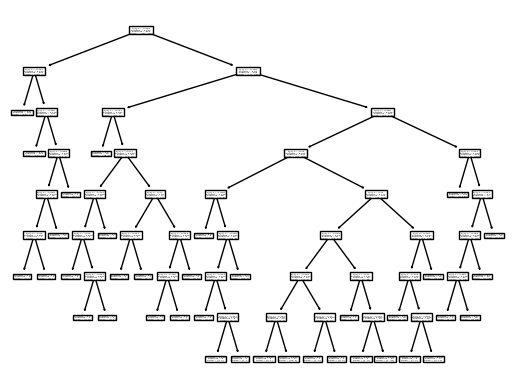

In [28]:
from sklearn import tree
tree.plot_tree(models3[7])
tree.export_graphviz(decision_tree=models3[7], class_names=True,out_file="Arbol Modelo Mejor Accuracy.dot")

## 11) Se varían otros hiperparámetros